# Approximating Governing Equations Using One-Step Residual Neural Networks

*This notebook shows my implimentation of the neural net using a JIT compiler to accelerate training. It takes 6 minutes to train 5,000 epochs, compared to around 60 minutes in plain NumPy. But I used SGD, since using Adam here would be a complicated mess.*

In [1]:
import time
import warnings
import numpy as np
from typing import List, Tuple
from numba import jit, njit
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from utils import get_error, get_errors, plot_trajectory, plot_multiple_trajectories

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.style.use('seaborn-whitegrid')

# Data Generation

In [2]:
def damped_pendulum(y, t, α, β):
        θ, dθdt = y     
        return dθdt, -α*dθdt - β*np.sin(θ)


def generate_damped_pendulum_solution(N_SAMPLES=25000, α=0.2, β=8.91, Δ=0.1, x0=[-1.193, -3.876], 
                                      dataset=False, t_end=25, noise=0.0):
    """
        :param N_SAMPLES - size of dataset if dataset=True
        :param α - parameter governing differential equation
        :param β - parameter governing differential equation
        :param Δ - time lag between solution state pairs
        :param x0 - initial conditions of differential equation, used if dataset=False
        :param dataset 
            True -  generate dataset of solution states pairs,  
            False - generate a single solution for a specified set of initial conditions x0.
        :param t_end: value of last timestep of ode solver, used if dataset=False
        :param noise - amount of random noise to add to solution states, used if dataset=True
    """
    if not dataset:
        t = np.linspace(0, t_end, 100000)
        sol = odeint(damped_pendulum, x0, t, args=(α, β))
        x = sol[:,0]
        dxdt = sol[:,1]
        return t, x, dxdt
    else:
        
        t = np.linspace(0, Δ, 10000)
    
        X = np.zeros((N_SAMPLES, 2))
        Y = np.zeros((N_SAMPLES, 2))

        for i in range(0,N_SAMPLES):
            if i%100==0:
                print("\r generating {} / {}".format(i+100, N_SAMPLES), end='')

            θ_0 = np.random.uniform(-np.pi, np.pi)
            dθdt_0 = np.random.uniform(-2*np.pi, 2*np.pi)
            x0 = [θ_0, dθdt_0]

            sol = odeint(damped_pendulum, x0, t, args=(α, β))
            ε_1 = np.random.uniform(-noise, noise)
            ε_2 = np.random.uniform(-noise, noise)

            θ_Δ = sol[-1,0]
            dθdt_Δ = sol[-1,1]

            X[i,0] = θ_0 + ε_1
            X[i,1] = dθdt_0 + ε_1

            Y[i,0] = θ_Δ + ε_2
            Y[i,1] = dθdt_Δ + ε_2

        return X, Y

# Neural Network Construction

Functions decorated with `@njit` can only include certain data structures and operations. Dictionaries are not allowed, which makes this implimentation very messy. Also no print statements, which makes debugging difficult. 

In [3]:
@njit(cache=True)
def init_layers():
    """
    Weights are initialized with random Gaussian distribution 
    biases are initialized with zeros. 
    """
    np.random.seed(99)
    
    L1_W = np.random.randn(30, 2).astype(np.float32)
    L1_b = np.zeros((30, 1), dtype=np.float32)
    
    L2_W = np.random.randn(30, 30).astype(np.float32)
    L2_b = np.zeros((30, 1), dtype=np.float32)
    
    L3_W = np.random.randn(2, 30).astype(np.float32)
    L3_b = np.zeros((2, 1), dtype=np.float32)
    
    L4_W = np.random.randn(2, 2).astype(np.float32)
    L4_b = np.zeros((2, 1), dtype=np.float32)

    return L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b


@njit(cache=True)
def tanh(Z):
    return np.tanh(Z).astype(np.float32)


@njit(cache=True)
def d_tanh(Z):
    dZ = 1 - np.tanh(Z)**2
    return dZ


@njit(cache=True)
def mean_squared_error(Y_hat, Y):
    m = Y_hat.shape[1] # number of examples
    cost = (1 / m) * np.sum( (Y - Y_hat)**2 )
    return cost


@njit(cache=True)
def forward_propagation(X, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b):

    # need to calculate Z for each layer. Store Z and A (not for the last layer)
    # M stands for "memory"
    L1_Z = np.dot(L1_W, X) + L1_b
    L1_A = tanh(L1_Z)
    L1_M_A_prev = X
    L1_M_Z = L1_Z
    
    L2_Z = np.dot(L2_W, L1_A) + L2_b
    L2_A = tanh(L2_Z)
    L2_M_A_prev = L1_A
    L2_M_Z = L2_Z
    
    L3_Z = np.dot(L3_W, L2_A) + L3_b
    L3_A = tanh(L3_Z)
    L3_M_A_prev = L2_A
    L3_M_Z = L3_Z
    
    L4_Z = np.dot(L4_W, L3_A + X) + L4_b
    L4_M_Z = L4_Z
    output = L4_Z
    
    return output, L1_M_Z, L2_M_Z, L3_M_Z, L4_M_Z, L1_M_A_prev, L2_M_A_prev, L3_M_A_prev
                   

@njit(cache=True)
def backward_propagation(
    Y_hat, Y, 
    L1_Z, L2_Z, L3_Z, L4_Z, L1_A_prev, L2_A_prev, L3_A_prev, # cache
    L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b, # params values
):
    # number of examples
    m = Y.shape[1]
    # initiate gradient descent algorithm (Derivative of mse loss function)
    dCost = 2*(Y_hat - Y)
    
    ####### Layer 4 (skip layer) #######
    L4_dZ = dCost
    L4_dW = np.dot(L4_dZ, L4_Z.T) / m
    L4_db = np.sum(L4_dZ, axis=1) / m
    # L4_db = np.expand_dims(L4_db, axis=1)
    L4_dA_prev = np.dot(L4_W.T, L4_dZ)
    
    ####### Layer 3 #######
    L3_dA = L4_dA_prev
    L3_dZ = L3_dA * d_tanh(L3_Z)
    L3_dW = np.dot(L3_dZ, L3_A_prev.T) / m
    L3_db = np.sum(L3_dZ, axis=1) / m
    # L3_db = np.expand_dims(L3_db, axis=1)
    L3_dA_prev = np.dot(L3_W.T, L3_dZ)
    
    ####### Layer 2 #######
    L2_dA = L3_dA_prev
    L2_dZ = L2_dA * d_tanh(L2_Z)
    L2_dW = np.dot(L2_dZ, L2_A_prev.T) / m
    L2_db = np.sum(L2_dZ, axis=1) / m
    # L2_db = np.expand_dims(L2_db, axis=1)
    L2_dA_prev = np.dot(L2_W.T, L2_dZ)
    
    ####### Layer 1 #######
    L1_dA = L2_dA_prev
    L1_dZ = L1_dA * d_tanh(L1_Z)
    L1_dW = np.dot(L1_dZ, L1_A_prev.T) / m
    L1_db = np.sum(L1_dZ, axis=1) / m
    # L1_db = np.expand_dims(L1_db, axis=1)
    L1_dA_prev = np.dot(L1_W.T, L1_dZ)
    
    return L1_dW, L1_db, L2_dW, L2_db, L3_dW, L3_db, L4_dW, L4_db
    
    
@njit(cache=True)
def update(lr, 
           L1_W,  L1_b,  L2_W,  L2_b,  L3_W,  L3_b,  L4_W,  L4_b, 
           L1_dW, L1_db, L2_dW, L2_db, L3_dW, L3_db, L4_dW, L4_db
):
    #print("L1_dW.shape: {} , L1_db.shape: {}".format(L1_dW.shape, L1_db.shape))
    L1_W -= lr * L1_dW
    L1_b -= lr * L1_db
    
    L2_W -= lr * L2_dW
    L2_b -= lr * L2_db
    
    L3_W -= lr * L3_dW
    L3_b -= lr * L3_db
    
    L4_W -= lr * L4_dW
    L4_b -= lr * L4_db
    
    return L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b


@njit(cache=True)
def train_on_batch(lr, X_batch, Y_batch, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b):
    
     # step forward
    Y_hat, L1_M_Z, L2_M_Z, L3_M_Z, L4_M_Z, L1_M_A_prev, L2_M_A_prev, L3_M_A_prev = forward_propagation(
        X_batch, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b
    )
    
    # calculate batch metrics and save them in history
    cost = mean_squared_error(Y_hat, Y_batch)
    
    # step backward - calculate gradients
    L1_dW, L1_db, L2_dW, L2_db, L3_dW, L3_db, L4_dW, L4_db = backward_propagation(
        Y_hat, Y_batch, 
        L1_M_Z, L2_M_Z, L3_M_Z, L4_M_Z, L1_M_A_prev, L2_M_A_prev, L3_M_A_prev, 
        L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b,
    )
    
    # Gradient descent step
    L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b = update(
        lr,
        L1_W,  L1_b,  L2_W,  L2_b,  L3_W,  L3_b,  L4_W,  L4_b,
        L1_dW, L1_db, L2_dW, L2_db, L3_dW, L3_db, L4_dW, L4_db
    )
    
    return cost, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b
    

@njit(cache=True)
def epoch_train(lr, X_batches, Y_batches, steps_per_epoch, 
    L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b
):
    epoch_train_cost = np.zeros((steps_per_epoch,))
    
    X_batches = X_batches.T
    Y_batches = Y_batches.T
    
    for idx in range(0, steps_per_epoch):
        
        X_batch = X_batches[:,:,idx]
        Y_batch = Y_batches[:,:,idx]

        cost, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b = train_on_batch(
            lr,
            X_batch,
            Y_batch,
            L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b
        )
        
        epoch_train_cost[idx] = cost

    return epoch_train_cost, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b
    


@njit(cache=True)
def fast_train(X_train, Y_train, epochs, X_valid, Y_valid, batch_size=10, 
               lr=0.001, patience=100, factor=0.5, min_lr=1e-5):
    
    min_cost = 1e12
    wait = 0
                
    # initiate neural net parameters
    L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b = init_layers()

    steps_per_epoch = int(len(X_train) // batch_size)
    train_cost_history = np.zeros((epochs,))
    valid_cost_history = np.zeros((epochs,))
    lr_history = np.zeros((epochs, ))
    train_length = len(X_train)

    # training loop ...
    for i in range(epochs):
        
        # Randomly shuffle the data at the beginning of each epoch
        shuffler = np.random.permutation(train_length)
        X_train_ = X_train[shuffler]
        Y_train_ = Y_train[shuffler]
        
        X_batches = np.zeros((steps_per_epoch, batch_size, 2))
        Y_batches = np.zeros((steps_per_epoch, batch_size, 2))
        
        for j in range(0, steps_per_epoch):
            idx_start = int(j*batch_size)
            idx_end = int(j*batch_size + batch_size)
            X_batches[j] = X_train_[idx_start:idx_end]
            Y_batches[j] = Y_train_[idx_start:idx_end]
            
        X_batches = X_batches.astype(np.float32)
        Y_batches = Y_batches.astype(np.float32)
        
        # Train over batches
        epoch_train_cost, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b = epoch_train(
            lr, X_batches, Y_batches, steps_per_epoch, 
            L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b
        )

        # step forward
        Y_hat, _, _, _, _, _, _, _ = forward_propagation(
            X_valid.T, L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b
        )
            
        epoch_valid_cost =  mean_squared_error(Y_hat, Y_valid.T)               
        epoch_mean_train_cost = np.mean(epoch_train_cost)
        train_cost_history[i] = epoch_mean_train_cost
        valid_cost_history[i] = epoch_valid_cost
        lr_history[i] = lr
        
        # Learning rate schedule
        if epoch_valid_cost < min_cost:
            # reset wait if performance metric improved
            min_cost = epoch_valid_cost
            wait = 0
        else:
            # increment wait if performance metric did not improve
            wait = wait + 1
            if (wait >= patience) and (lr > min_lr):
                lr = lr * factor
                wait = 0
        

    return L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b, train_cost_history, valid_cost_history, lr_history




def run_fast_train(X_train, Y_train, epochs, X_valid, Y_valid, batch_size=10, lr=0.001,
                   lr_sch={"patience":100, "factor":0.5, "min_lr":1e-5}):
    
    # For learning schedule ...
    
    patience = lr_sch["patience"]
    factor = lr_sch["factor"]
    min_lr = lr_sch["min_lr"]
    
    L1_W, L1_b, L2_W, L2_b, L3_W, L3_b, L4_W, L4_b, train_hist, valid_hist, lr_hist = fast_train(
        X_train, Y_train, epochs, X_valid, Y_valid, batch_size, lr, patience, factor, min_lr
    )
    
    history = [train_hist, valid_hist, lr_hist]
    
    params_values = {
        "W1": L1_W, "b1": L1_b,
        "W2": L2_W, "b2": L2_b,
        "W3": L3_W, "b3": L3_b,
        "W4": L4_W, "b4": L4_b,
    }
    return params_values, history

In [4]:
def predict(X, params):
    """Prediction on a single datapoint"""
    y , _, _, _, _, _, _, _ = forward_propagation(
        np.expand_dims(X.astype(np.float32), axis=0).T,
        params["W1"].astype(np.float32), params["b1"].astype(np.float32),
        params["W2"].astype(np.float32), params["b2"].astype(np.float32), 
        params["W3"].astype(np.float32), params["b3"].astype(np.float32), 
        params["W4"].astype(np.float32), params["b4"].astype(np.float32),
    )
    return y


def predict_batch(X, params):
    """Prediction on a batch of datapoints"""
    y , _, _, _, _, _, _, _ = forward_propagation(
        X.astype(np.float32),
        params["W1"].astype(np.float32), params["b1"].astype(np.float32),
        params["W2"].astype(np.float32), params["b2"].astype(np.float32), 
        params["W3"].astype(np.float32), params["b3"].astype(np.float32), 
        params["W4"].astype(np.float32), params["b4"].astype(np.float32),
    )
    return y

# Model Training and Evaluation

SGD takes forever to converge, so I found 20,000 epochs gives the best results. Also the number of datapoints is increased slightly to prevent overfitting.

In [5]:
X, Y = generate_damped_pendulum_solution(
    N_SAMPLES=30000, α=0.2, β=8.91, Δ=0.1, dataset=True, noise=0.0)
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

 generating 30000 / 30000

In [6]:
start = time.time()

params_values, history = run_fast_train(
    X_train = X_train.astype(np.float32),
    Y_train = y_train.astype(np.float32), 
    epochs = 20000, 
    X_valid = X_valid.astype(np.float32),
    Y_valid = y_valid.astype(np.float32),
    batch_size = 10,
    lr = 0.001,
    lr_sch={"patience":200, "factor":0.5, "min_lr":1e-5}
)

end = time.time()
print("\n Time: {:.2f} minutes".format((end-start)/60))


 Time: 33.84 minutes


In [7]:
def plot_history(history): 
    train_loss = history[0]
    valid_loss = history[1]   
    learning_rate = history[2]
    epochs = range(len(train_loss))
    plt.figure(figsize=(16,7))
    plt.plot(epochs, train_loss, c='b', linewidth=3, alpha=0.7, label="Training")
    plt.plot(epochs, valid_loss, c='r', linewidth=3, alpha=0.7, label="Validation")
    plt.plot(epochs, learning_rate, c='g', linewidth=3, alpha=0.4, label="Learning Rate")
    plt.title('Training and Validation Loss',fontsize=22)
    plt.yscale("log")
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(prop={"size":18})
    plt.show()

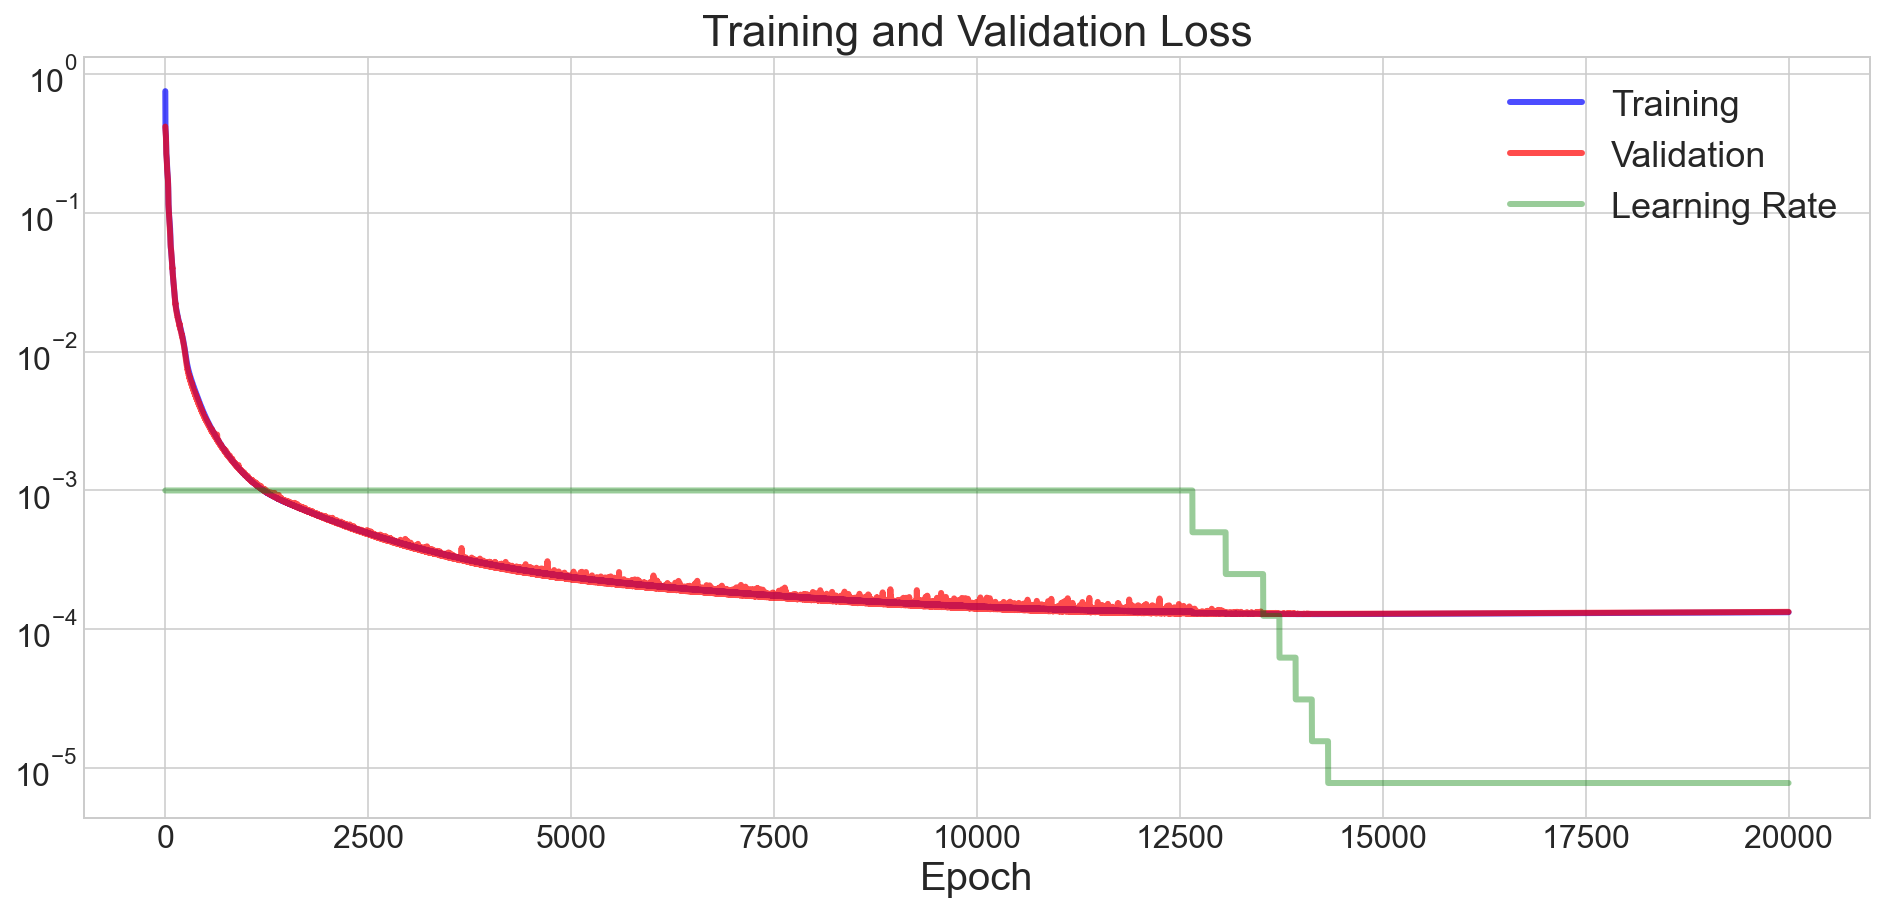

In [8]:
plot_history(history)

In [9]:
np.save("numpy_model_JIT_params_values.npy", params_values)
# params_values = np.load("numpy_model_JIT_params_values.npy", allow_pickle=True)
# params_values = numpy_model_JIT_params_values[()]

In [10]:
def predict_solution(params_values, Δ=0.1, t_end=20):

    t_steps = np.arange(0,t_end, Δ)
    X_pred = np.zeros((len(t_steps), 2))

    x_0 = np.array([-1.193, -3.876])
    x_Δ = np.array([-1.193, -3.876])
    
    for i in range(0, len(t_steps)):
        x_0 = x_Δ
        x_Δ = predict(x_0, params_values)
        x_Δ = np.squeeze(x_Δ.T)
        X_pred[i] = x_Δ   
        
    t_steps = t_steps + Δ
    return t_steps, X_pred

In [11]:
t_steps, X_pred = predict_solution(params_values=params_values, Δ=0.1, t_end=20)  
t, x, dxdt = generate_damped_pendulum_solution(dataset=False, α=0.2, β=8.91, Δ=0.1, t_end=20)

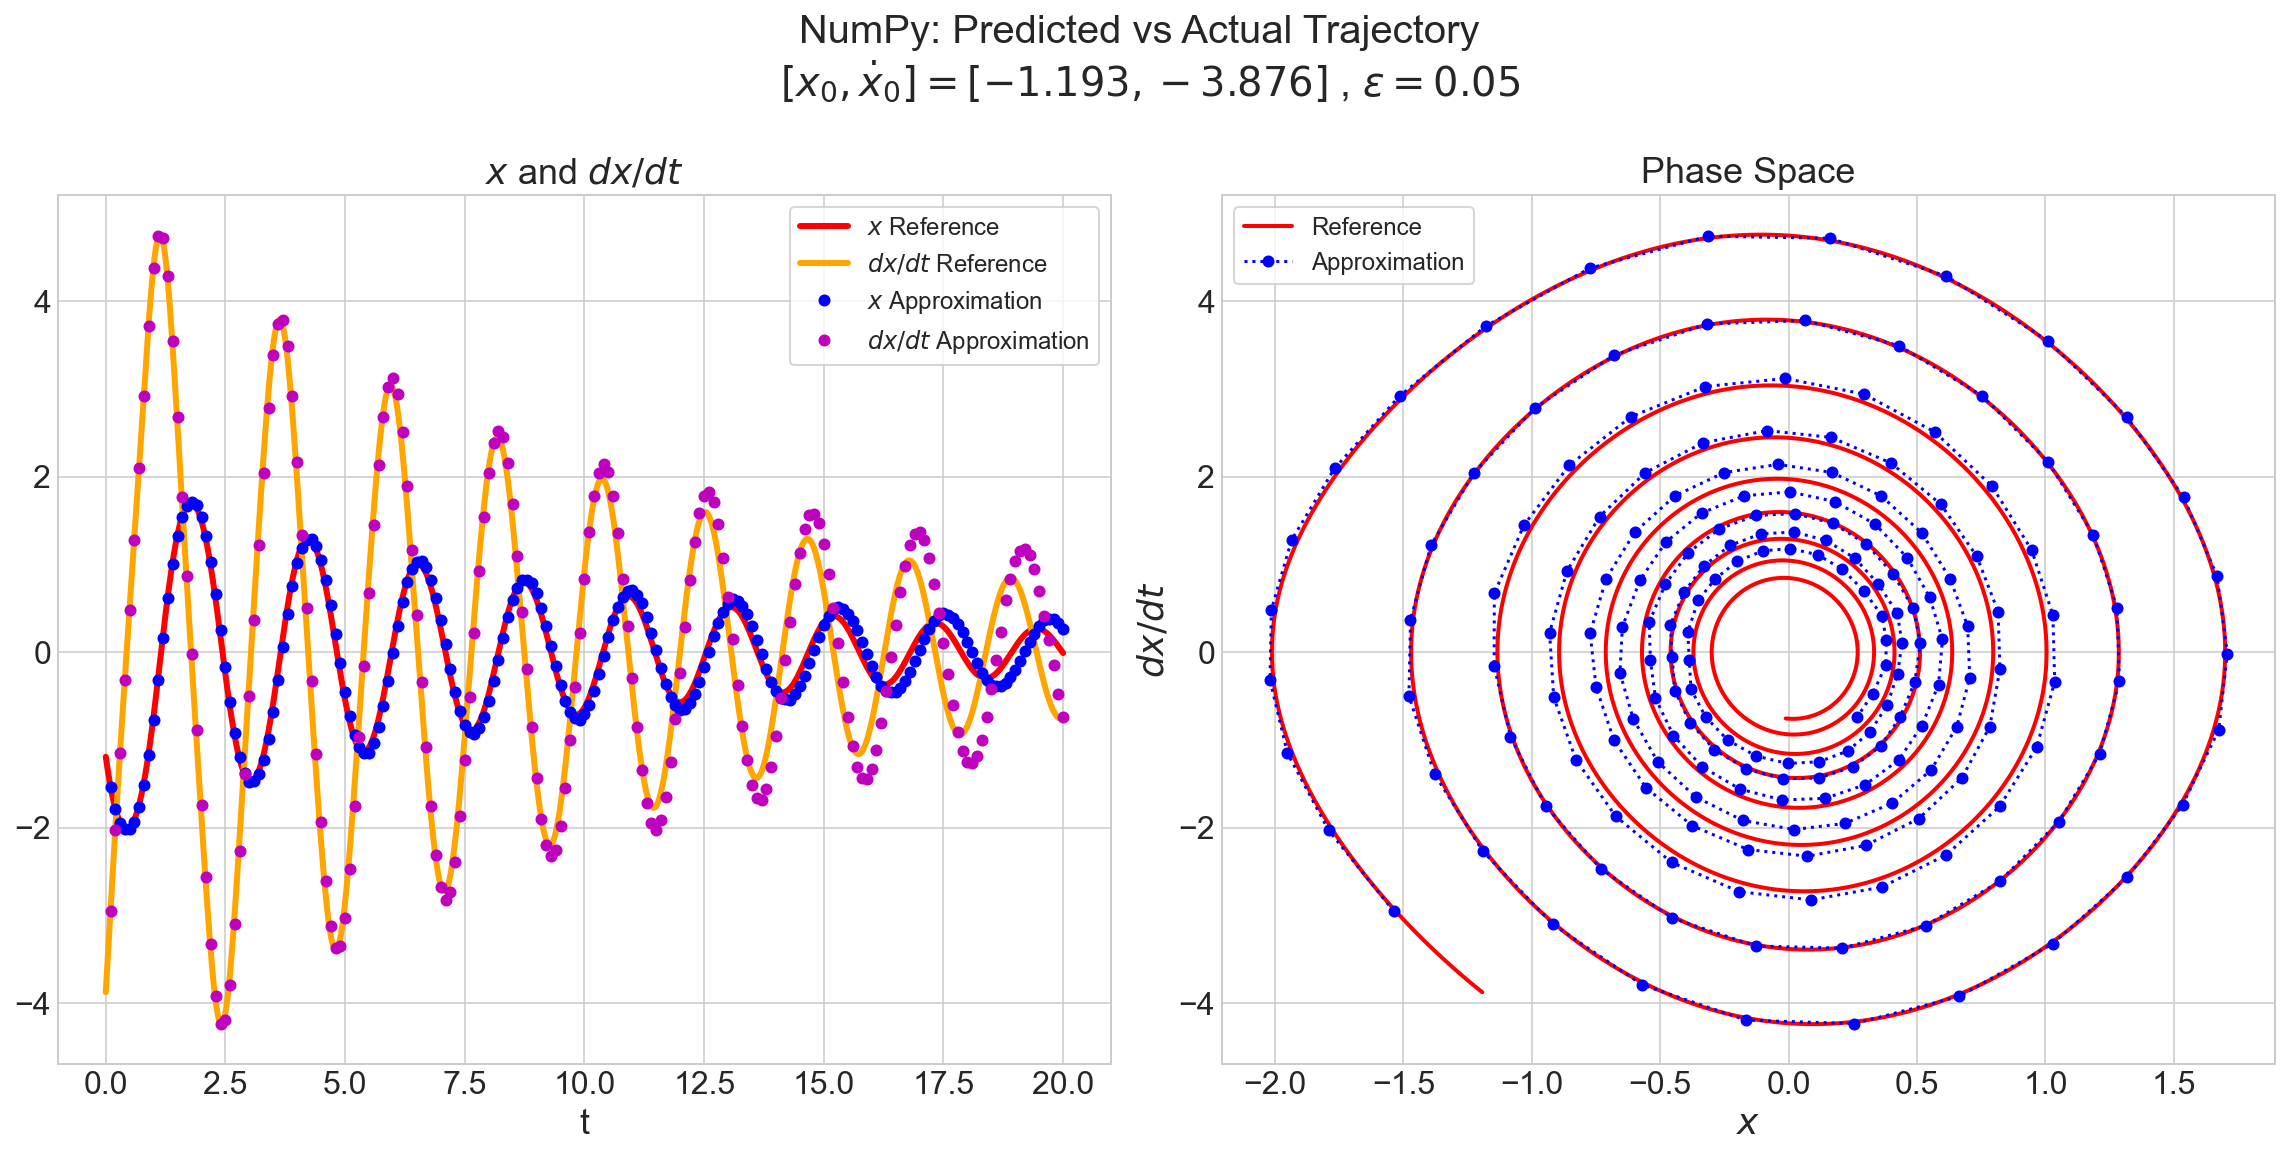

In [12]:
plot_trajectory(t, t_steps, x, dxdt, X_pred, 
    title="NumPy: Predicted vs Actual Trajectory \n "
    "$[x_{0}, \dot{x}_{0}] = [-1.193, -3.876]$ , $\epsilon=0.05$"
)

In [13]:
def predict_multiple_solutions(n_solutions, params_values, Δ=0.1, t_end=20, α=0.2, β=8.91):
    
    t = np.linspace(0, t_end, 10000)
    t_steps = np.arange(0,t_end, Δ)
    
    X_pred = np.zeros((n_solutions, len(t_steps)))
    X_true = np.zeros((n_solutions, len(t)))
    
    X0_arr = np.zeros((n_solutions, 2))
    XΔ_arr = np.zeros((n_solutions, 2))
    
    for i in range(0, n_solutions):        
        x0_i = [np.random.uniform(-np.pi, np.pi), np.random.uniform(-2*np.pi, 2*np.pi)]
        sol = odeint(damped_pendulum, x0_i, t, args=(α, β))
        X0_arr[i] = x0_i
        X_true[i] = sol[:,0]
        
    XΔ_arr = X0_arr.T
    
    for j in range(0, len(t_steps)):
        print("\r Stepping {} / {}".format(j+1, len(t_steps)), end='')
        X0_arr = XΔ_arr
        XΔ_arr = predict_batch(X0_arr, params_values)
        X_pred[:,j] = XΔ_arr[0,:]        
        
    t_steps = t_steps + Δ
    return t, t_steps, X_true, X_pred

In [14]:
N_predictions = 5000

In [15]:
t1, t_steps1, X_true_arr1, X_pred_arr1 = predict_multiple_solutions(
    n_solutions = N_predictions,
    params_values = params_values,
    Δ = 0.1,
    t_end = 20
) 

 Stepping 200 / 200

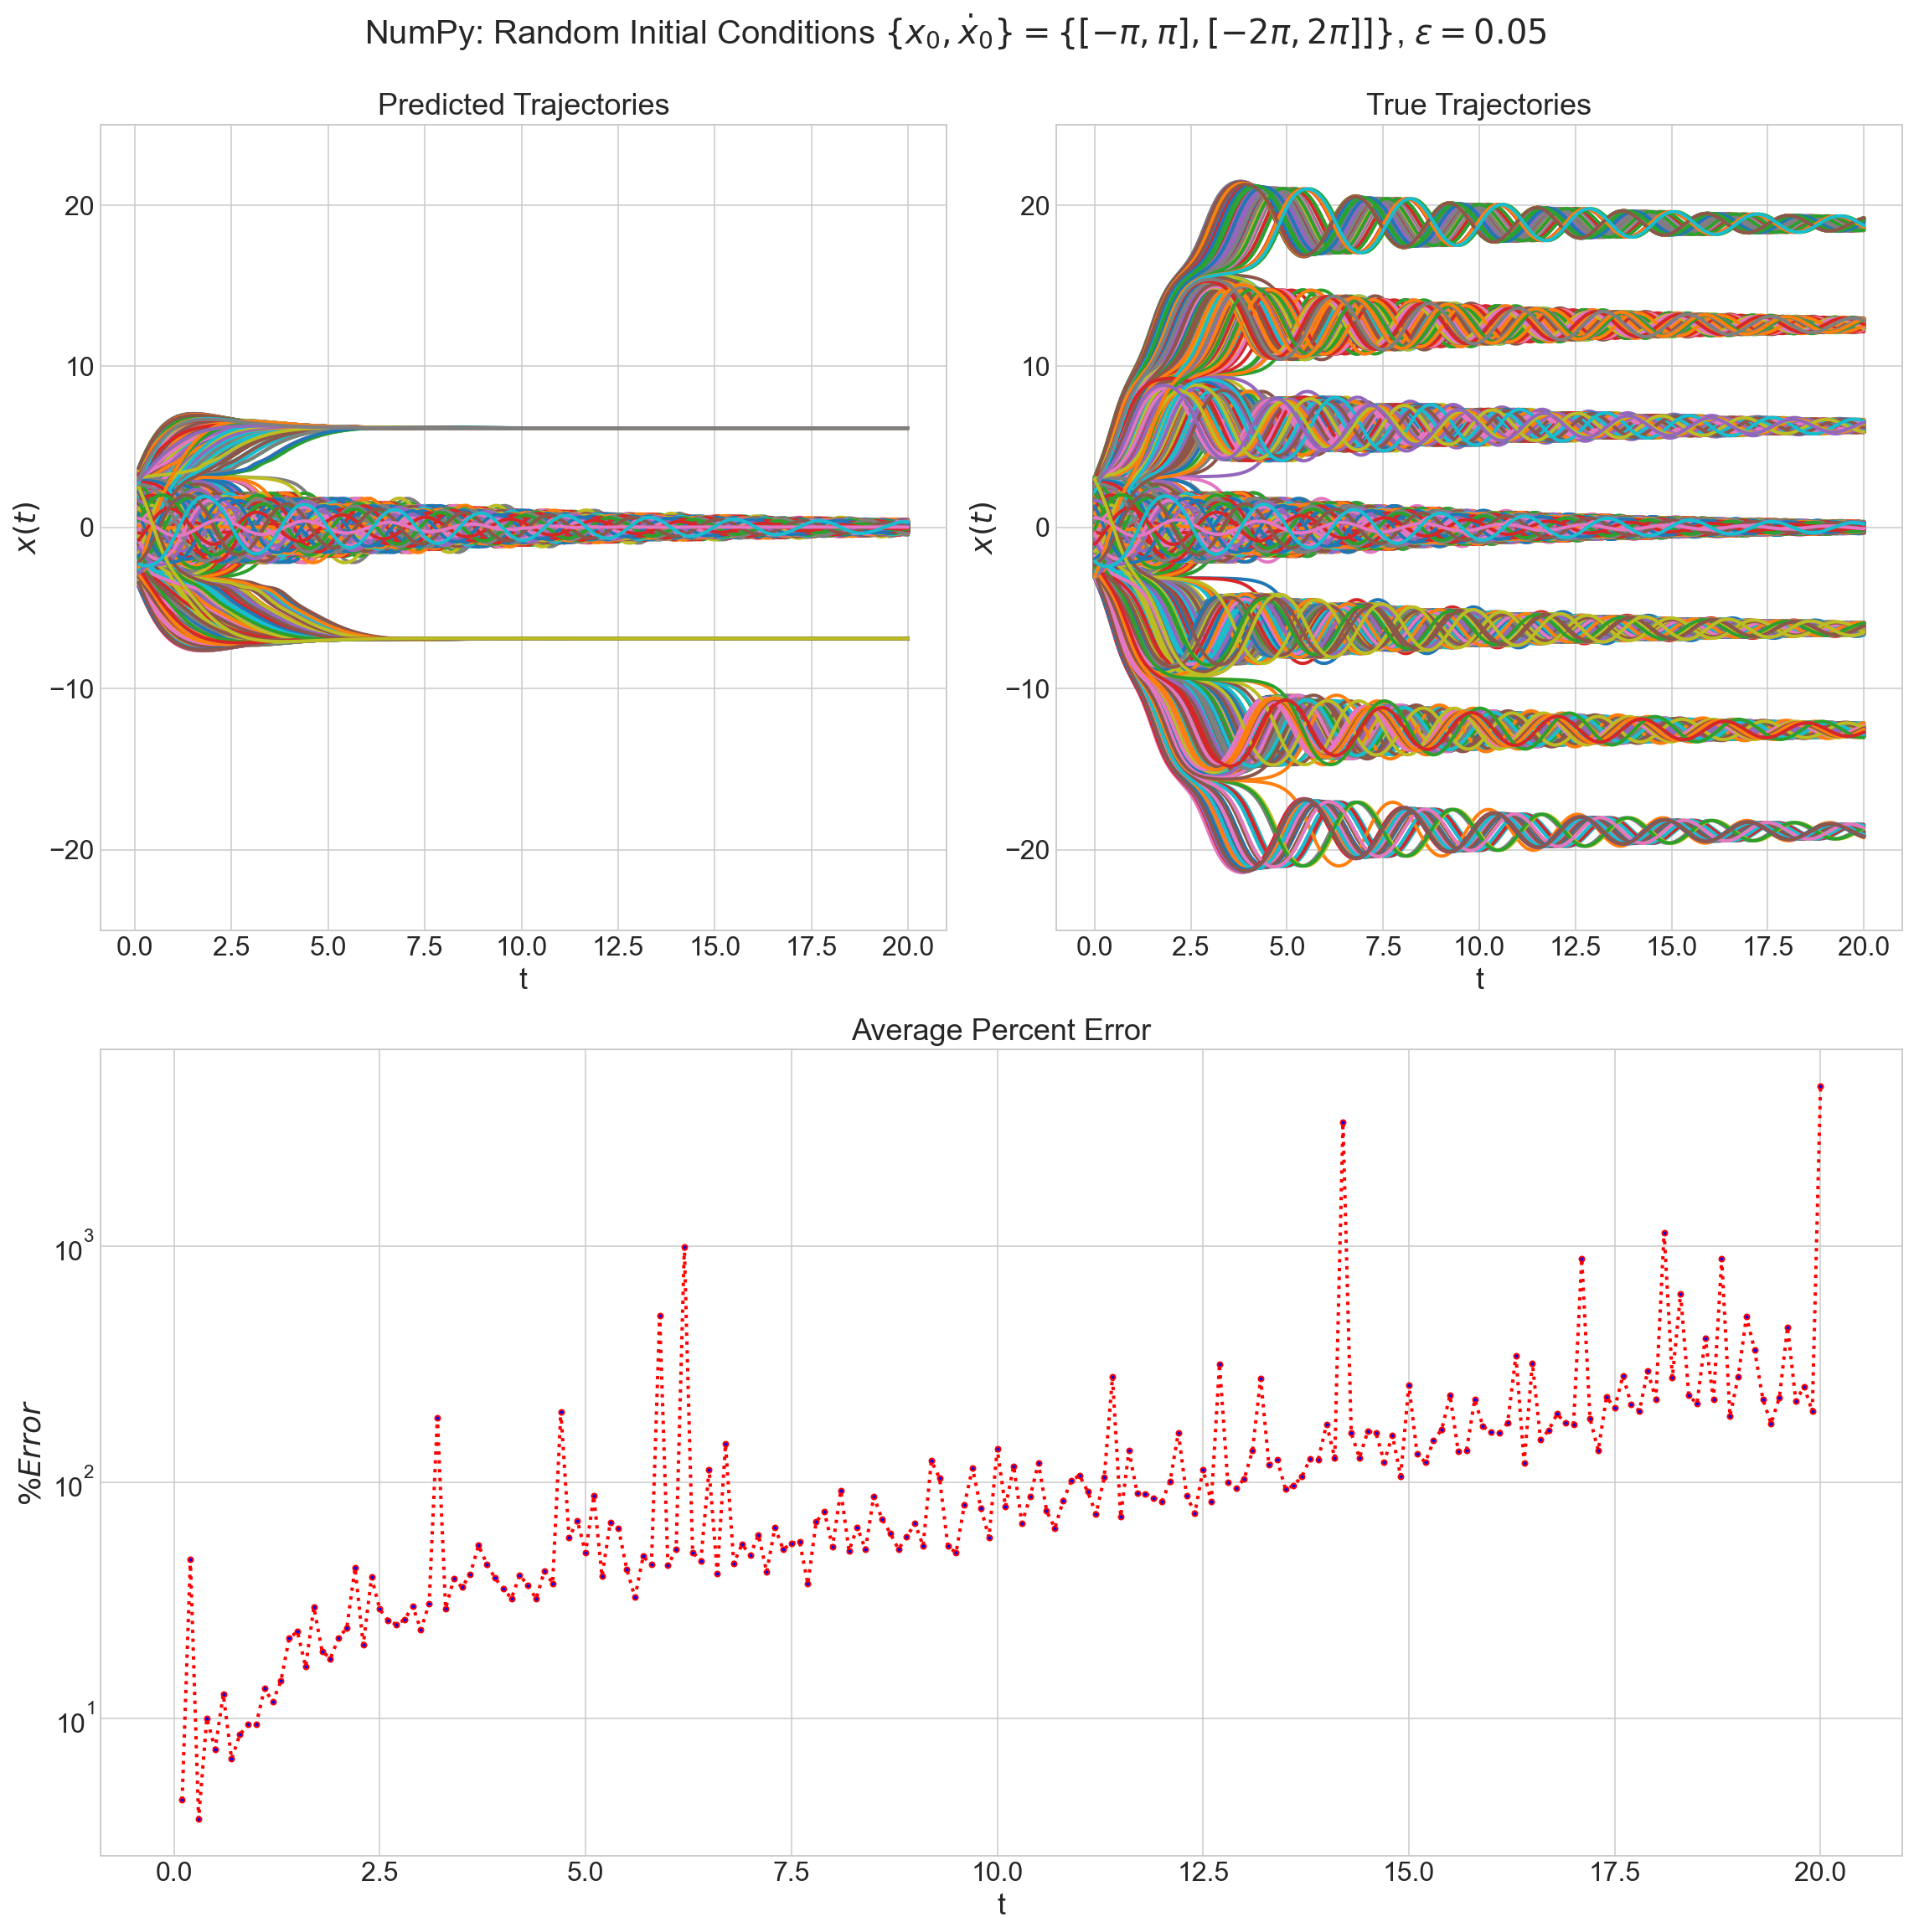

In [16]:
plot_multiple_trajectories(t1, t_steps1, X_true_arr1, X_pred_arr1, 
    n_samples=5000, up_ylim=[-25,25],
    title="NumPy: Random Initial Conditions "
    "$\{x_{0},\dot{x}_{0}\} = \{[-\pi,\pi],[-2\pi,2\pi]] \}$, $\epsilon = 0.05$"
)